# Optimized KF: Simple Training Example

In [1]:
# Auto reload
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import pickle as pkl
from collections import Counter
import gc

import torch
import torch.nn.functional as F

import utils
import TargetSimulator as Sim
import SensorGenerator as Rad
import Trackers
import NeuralTrackers as NT
import TrackingLab as TLAB
import PredictionLab as PLAB

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:90% !important; }</style>"))
np.set_printoptions(precision=3)
np.set_printoptions(linewidth=150)
np.set_printoptions(suppress=True)
torch.set_printoptions(linewidth=150)

# Data

- Training input (X): list of targets; each target $X_i$ is of size $L_i\times 4$, where `X[i][t,j]` is the $j$'s detection component (x/y/z/doppler) at time $t$.
- Test input (X2): same structure as X.
- Training output (Y): list of targets; each target $Y_i$ is of size $L_i\times 6$, where `Y[i][t,j]` is the $j$'s detection component (x/y/z/vx/vy/vz) at time $t$.
- Test output (Y2): same structure as Y.

#### Non-uniform time differences
For non-uniform time differences (i.e. varying $dt$), $X$ and/or $Y$ should have an extra column of time in the beginning, i.e. `X[i][:,0]` (and/or `Y[i][:,0]`) would contain the times associated with the observations.

In [3]:
X,Y,scenarios_train = PLAB.load_data(fname=f'train00')
X2,Y2,scenarios_test = PLAB.load_data(fname=f'test00')

In [4]:
type(X), len(X), type(X[0]), X[0].shape

(list, 4000, numpy.ndarray, (77, 4))

In [5]:
type(Y), len(Y), type(Y[0]), Y[0].shape

(list, 4000, numpy.ndarray, (77, 6))

For analysis of the trajectories in the data, use the *Experiment* class as demonstrated in the *Neural Kalman Filter* notebook.

# Training

We demonstrate the training with the following models:
- KF: standard KF. The "training" is simply estimation of $R,Q$ from the training data.
- OKF: optimized KF, where $R,Q$ are learned to optimize the MSE over the training data.
- OKF_p: same as OKF, but with $R$ represented in polar coordinates.

In [6]:
models_args = [
    dict(load=False, title='KF_demo', no_acc=True),
    dict(load=False, title='OKF_demo', no_acc=True, const_R=False, const_Q=False),
    dict(load=False, title='OKF_p_demo', no_acc=True, const_R=False, const_Q=False, polar_R=True),
]

gc.collect()

60

Waiting for trainings...
Waiting for processes...
Done.	(3293 [s])
Best validation losses:
	KF_demo: inf (KF_demo_s00)
	OKF_demo: 111 (OKF_demo_s00)
	OKF_p_demo: 109 (OKF_p_demo_s00)


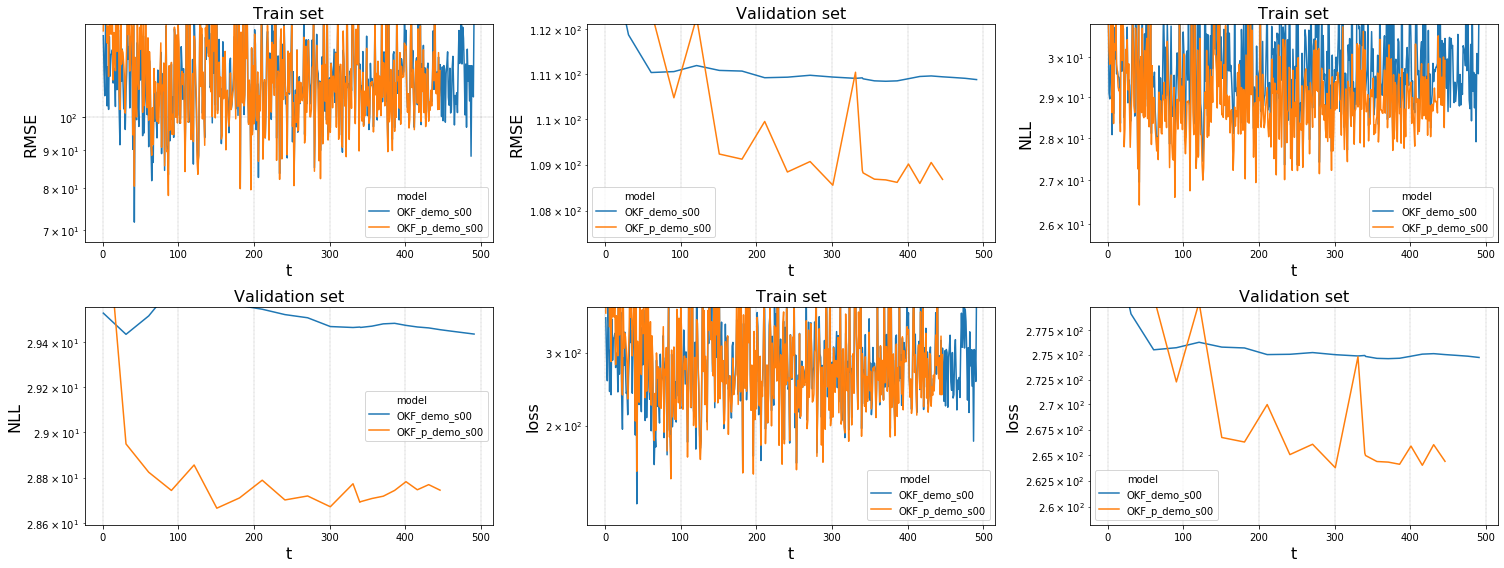

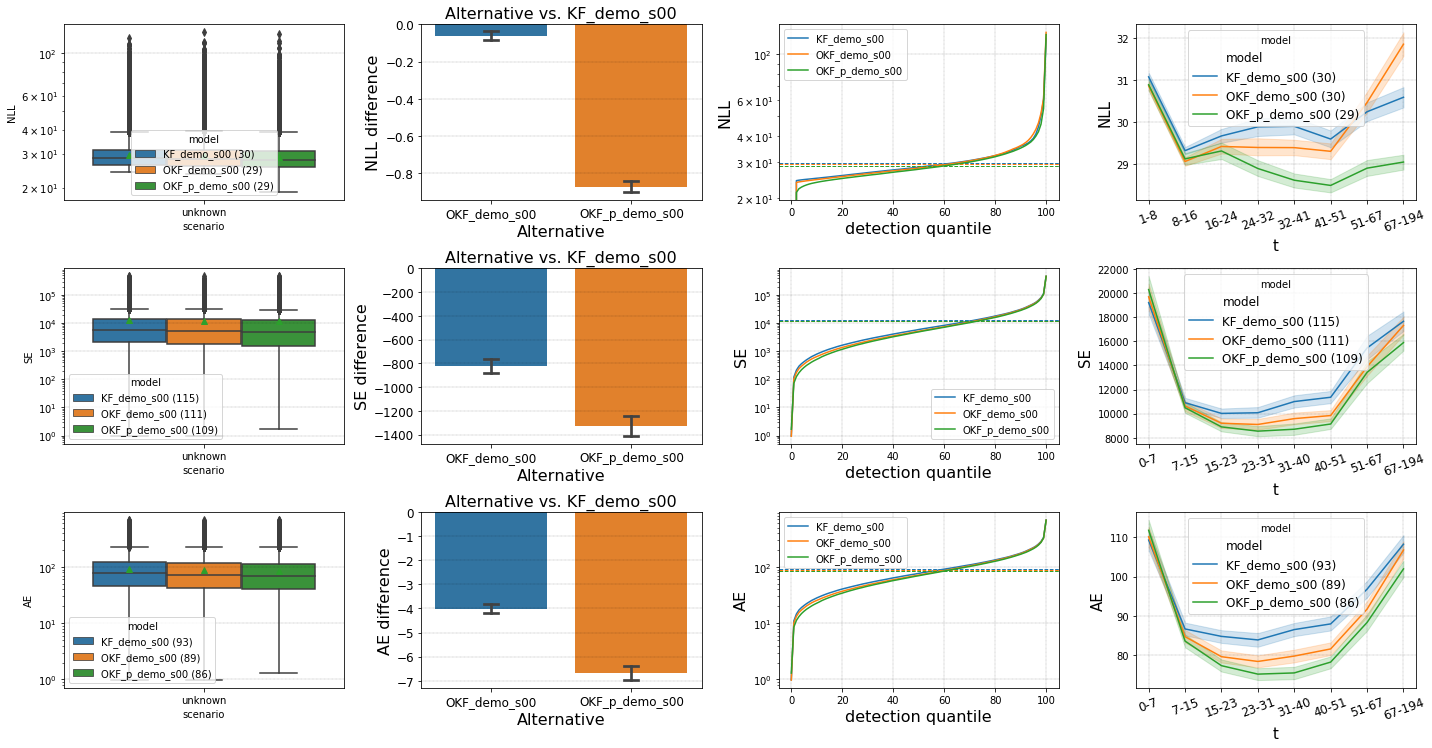

In [8]:
# train
# for longer training - increase n_epochs; for shorter - set tune_phase=False.
models, train_res, valid_res, _, _, losses = \
    PLAB.train_models(models_args, X, Y, seeds=1, save_res=f'demo', model_fname_prefix=f'demo',
                      n_epochs=1, batch_size=10, tune_phase=True, lr=1e-2, verbose=2)

# show training & validation results
PLAB.train_summary(train_res, ylim_quant=90);
PLAB.test_analysis(valid_res);

# Testing

3 models are split to 1 batches.
Running 20 threads...
Finished models-batch 1/1.	(70 [s])


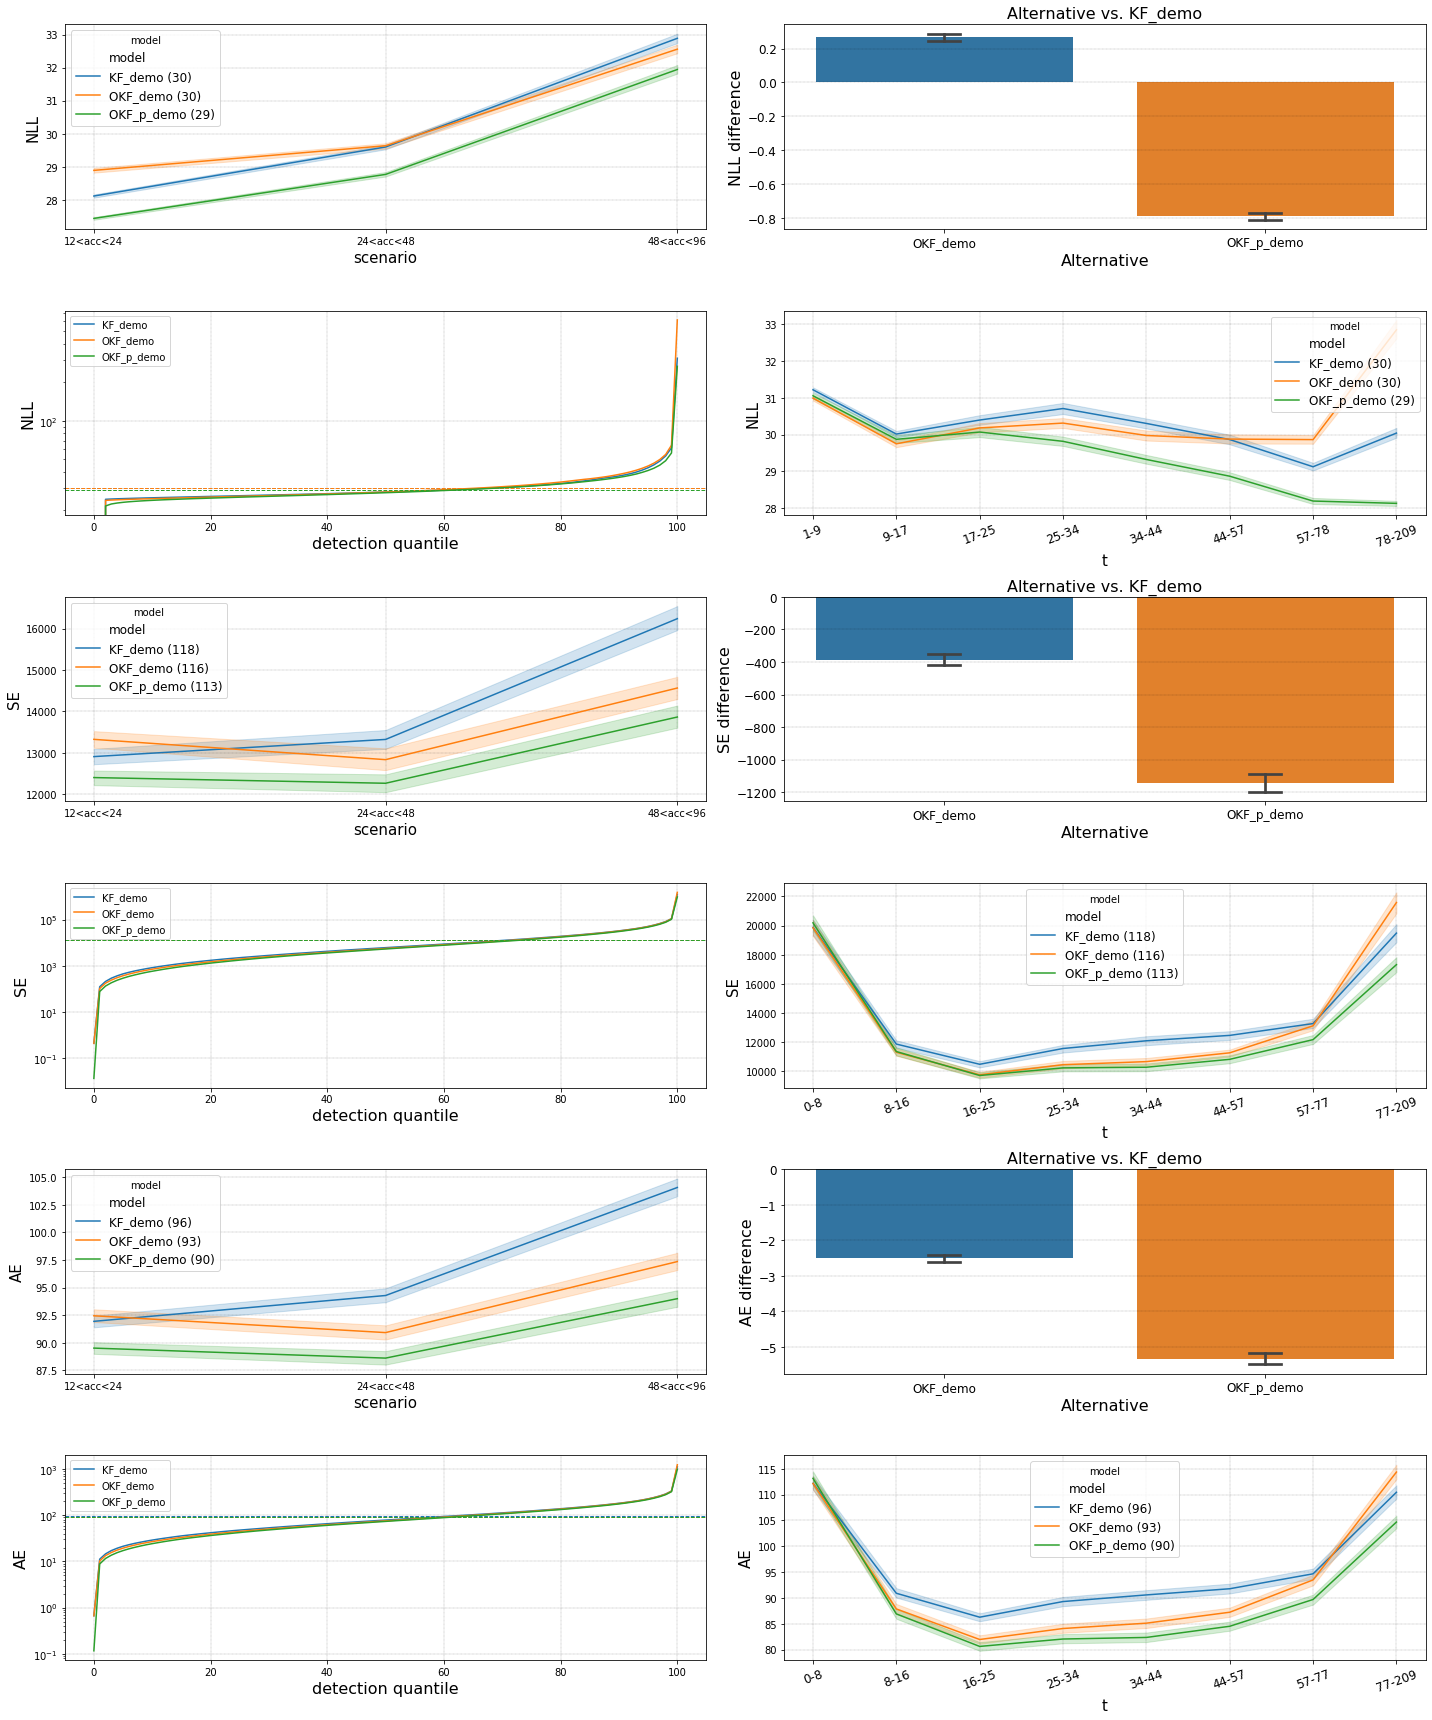

In [9]:
res = PLAB.test_models(models, X2, Y2, scenarios_test)
axs = PLAB.test_analysis(res, axargs=dict(W=2, axsize=(10,4)))

To test the models over a complete tracking task, use the *Experiment* class as demonstrated in the *Neural Kalman Filter* notebook.